🛑 Read-only demo notebook

This file shows how the blog images are generated.
It is **not** part of the production pipeline.

In [ ]:
from pathlib import Path
import os, shutil, io, requests, subprocess, tempfile
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
from rasterio.plot import show
from PIL import Image, ImageDraw, ImageFont
from graphviz import Digraph            # !pip install graphviz
from matplotlib import patheffects as pe

DATA     = Path("data/raw")
OUTIMG   = Path("blog_images");  OUTIMG.mkdir(parents=True, exist_ok=True)

# Kenya bbox (S, N, W, E)
BBOX = (-4.62, 4.62, 33.5, 41.9)

def fetch(url:str, dest:Path, *, ttl_hr=24):
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists() and (pd.Timestamp.now() - pd.Timestamp(dest.stat().st_mtime)
                           ).total_seconds() < ttl_hr*3600:
        return dest
    print(f"⬇️  Downloading {url.split('/')[-1]} …")
    r = requests.get(url, timeout=120)
    r.raise_for_status()
    dest.write_bytes(r.content)
    return dest


TypeError: 'str' object is not a mapping

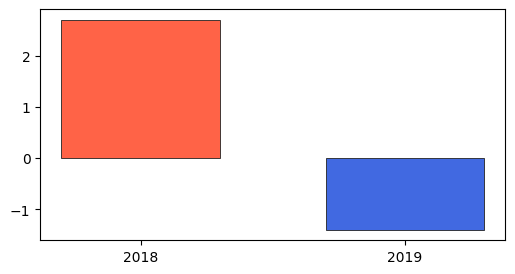

In [21]:
# hero_spi.py  – run inside visuals.ipynb or as a script
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── load two reference seasons ─────────────────────────────
season = pd.read_csv("data/processed/season_totals.csv")
season["spi3_1dp"] = season["spi3"].round(1)

sel = (season.query("year in [2018, 2019]")
              .set_index("year"))


# ── plot ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 3))

colors = ["tomato" if v > 0 else "royalblue" for v in sel.spi3_1dp]

bars = ax.bar(
    sel.index.astype(str),
    sel.spi3_1dp, 
    width=0.6,
    color=colors,
    edgecolor="#222",        # thin outline
    linewidth=0.6,
)

# value labels just above / below bars
for bar, v in zip(bars, sel.spi3_1dp):
    height = bar.get_height()
    offset = 0.03 * np.sign(height)          # tweak for spacing
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + offset,
        f"{height:+.1f}",
        f"{v:+.1f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=8,
        color="#333"
    )

# style tweaks
ax.axhline(0, color="#666", lw=1)
ax.set_ylabel("SPI-3 z-score")

ax.set_title("Kenya Long-Rains • Flood vs Drought Snapshot")

# tidy axis: only the two year labels, no ticks elsewhere
ax.set_xticks(sel.index.astype(str))
ax.set_xticklabels(sel.index.astype(str))
ax.tick_params(axis='x', length=0)          # hide little tick marks

ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()

out_path = Path("blog_images/spi_hero.png")
out_path.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(out_path, dpi=300)
plt.show()

print(f"✅ Hero saved to {out_path.relative_to(Path.cwd())}")


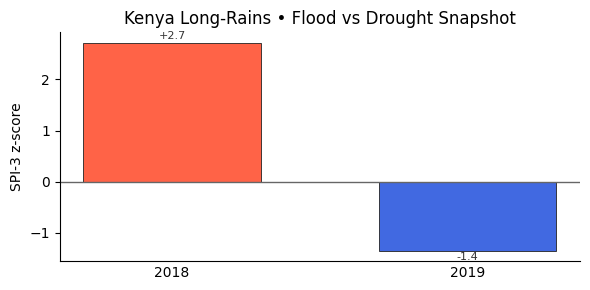

ValueError: 'blog_images\\spi_hero.png' does not start with 'c:\\Projects\\East-African-Monsoon-ML-project'

In [20]:
# hero_spi.py  – run inside visuals.ipynb or as a script
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── load two reference seasons ─────────────────────────────
season = pd.read_csv("data/processed/season_totals.csv")
sel    = (season.query("year in [2018, 2019]")
                  .set_index("year"))


# ── plot ──────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 3))

colors = ["tomato" if v > 0 else "royalblue" for v in sel.spi3]

bars = ax.bar(
    sel.index.astype(str), sel.spi3,
    width=0.6,
    color=colors,
    edgecolor="#222",        # thin outline
    linewidth=0.6,
)

# value labels just above / below bars
for bar in bars:
    height = bar.get_height()
    offset = 0.03 * np.sign(height)          # tweak for spacing
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + offset,
        f"{height:+.1f}",
        ha="center",
        va="bottom" if height > 0 else "top",
        fontsize=8,
        color="#333"
    )

# style tweaks
ax.axhline(0, color="#666", lw=1)
ax.set_ylabel("SPI-3 z-score")

ax.set_title("Kenya Long-Rains • Flood vs Drought Snapshot")

# tidy axis: only the two year labels, no ticks elsewhere
ax.set_xticks(sel.index.astype(str))
ax.set_xticklabels(sel.index.astype(str))
ax.tick_params(axis='x', length=0)          # hide little tick marks

ax.spines[['right', 'top']].set_visible(False)

plt.tight_layout()

out_path = Path("blog_images/spi_hero.png")
out_path.parent.mkdir(exist_ok=True, parents=True)
plt.savefig(out_path, dpi=300)
plt.show()

print(f"✅ Hero saved to {out_path.relative_to(Path.cwd())}")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Projects\\blog_images\\spi_bars.png'

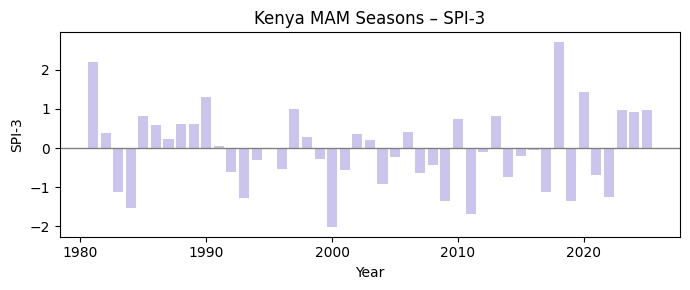

In [4]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from pathlib import Path

# Load season totals produced by your pipeline
season = pd.read_csv("data\processed\season_totals.csv")
fig, ax = plt.subplots(figsize=(7,3))
ax.bar(season.year, season.spi3, color="slateblue", alpha=.35)
ax.axhline(0, color="grey", lw=1)
ax.set_title("Kenya MAM Seasons – SPI-3")
ax.set_xlabel("Year"); ax.set_ylabel("SPI-3")
plt.tight_layout(); plt.savefig("../blog_images/spi_bars.png", dpi=200)


In [ ]:
tile_url  = ("https://data.chc.ucsb.edu/products/CHIRPS/v3.0/monthly/africa/"
             "tifs/chirps-v3.0.2018.03.tif")          
tile_path = fetch(tile_url, DATA / "chirps_2018_03.tif")

thumb_png = OUTIMG / "tile_thumb.png"
if not thumb_png.exists():
    with rasterio.open(tile_path) as src:
        arr = src.read(1)
        arr = np.ma.masked_where(arr <= -9990, arr)
        plt.imsave(thumb_png, arr, cmap="Blues")


In [ ]:
chart_png = Path("outputs/season_totals.png")
assert chart_png.exists(), "Run your main pipeline first so the chart exists!"

hero_png = OUTIMG / "hero_mam_pipeline.png"
if not hero_png.exists():
    tile_im   = Image.open(thumb_png).resize((600, 600))
    chart_im  = Image.open(chart_png).resize((600, 600))
    hero      = Image.new("RGB", (1200, 600), "white")
    hero.paste(tile_im,  (0,   0))
    hero.paste(chart_im, (600, 0))

    draw = ImageDraw.Draw(hero)
    font = ImageFont.load_default()
    txt  = "From GeoTIFF ➜ Insight"

    x0, y0, x1, y1 = draw.textbbox((0, 0), txt, font=font)
    w, h           = x1 - x0, y1 - y0

    draw.rectangle([(0, 0), (w + 20, h + 20)], fill="white")
    draw.text((10, 10), txt, fill="black", font=font)
    hero.save(hero_png, optimize=True)
print("✅ hero image →", hero_png)


In [ ]:
!pip install graphviz

In [ ]:
flow = Digraph("ingestion", format="png")
flow.attr(rankdir="LR", fontname="Calibri")
flow.node("user",      "Notebook / Pipeline", shape="box", style="filled", fillcolor="#CDEAFE")
flow.node("cache",     "On-disk cache\n(data/raw)", shape="folder")
flow.node("primary",   "Primary URL\n(CHIRPS Monthly)", shape="component")
flow.node("fallback",  "Fallback URL\n(CHIRPS Daily)",  shape="component")
flow.edges([("user", "cache"), ("cache", "primary"),
            ("primary", "user"), ("primary", "fallback"), ("fallback", "user")])

flow_png = flow.render(OUTIMG / "ingestion_flow", cleanup=True)
print("✅ flow-chart →", flow_png)


In [ ]:
from graphviz import Digraph, ExecutableNotFound
import shutil, sys, pathlib

OUTIMG = pathlib.Path("blog_images")

def build_flowchart() -> pathlib.Path:
    g = Digraph(format="png")
    g.attr(rankdir="LR", newrank="true")
    g.node("URL",      "CHIRPS\nURL")
    g.node("Cache",    "Local\ncache")
    g.node("Fallback", "Daily tiles\nfallback")
    g.node("Raster",   "Kenya bbox\nclip & mean")
    g.edges([("URL", "Cache"), ("Cache", "Raster"),
             ("URL", "Fallback"), ("Fallback", "Raster")])
    out = OUTIMG / "ingestion_flow.png"
    try:
        g.render(out.with_suffix(""), cleanup=True)    # writes .png
    except ExecutableNotFound:
        print("⚠️  Graphviz engine not found – skipping flowchart."
              "  Install Graphviz and ensure 'dot' is on PATH.")
        return None
    return out

flow = build_flowchart()
if flow:
    print("Saved:", flow)


In [ ]:
clip_png = OUTIMG / "clip_before_after.png"
if not clip_png.exists():
    # clip to Kenya bbox
    with rasterio.open(tile_path) as src:
        win  = from_bounds(BBOX[2], BBOX[0], BBOX[3], BBOX[1], src.transform)
        kenya = src.read(1, window=win)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    show(rasterio.open(tile_path).read(1), ax=axs[0], cmap="Blues")
    axs[0].set_title("Full CHIRPS tile (Africa)")
    
    show(kenya, ax=axs[1], cmap="Blues")
    axs[1].set_title("Clipped to Kenya")
    plt.tight_layout()
    plt.savefig(clip_png, dpi=120)
    plt.close()
print("✅ clip illustration →", clip_png)


In [ ]:
from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

DATA   = Path("data/processed/season_totals.csv")
OUTIMG = Path("blog_images"); OUTIMG.mkdir(parents=True, exist_ok=True)

season = pd.read_csv(DATA)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(season["year"], season["spi3"],
       color="#8E5EFF", alpha=.30, edgecolor="none")
ax.axhline(0, color="gray", lw=1)
ax.set(
    title="Kenya March–May | SPI-3 drought ↔ flood index",
    xlabel="Year", ylabel="SPI-3 (σ units)")
sns.despine()
fig.tight_layout()
fig.savefig(OUTIMG / "spi3_bars.png", dpi=150)
plt.close(fig)


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path

RAW = Path("data/raw/chirps_mam.csv")
OUT = Path("blog_images/elbow_kmeans.png")

df = pd.read_csv(RAW)
pivot = (df.pivot(index="year", columns="month", values="rain_mm")
           .reindex(columns=[3, 4, 5])
           .dropna())                         # keep complete seasons only

scaled = StandardScaler().fit_transform(pivot)

inertias = [
    KMeans(k, n_init="auto", random_state=0).fit(scaled).inertia_
    for k in range(1, 8)
]

plt.plot(range(1, 8), inertias, marker="o")
plt.title("Elbow method – where the curve bends, stop adding clusters")
plt.xlabel("k  (number of clusters)")
plt.ylabel("Within-cluster SSE")
plt.tight_layout()
plt.savefig(OUT, dpi=150)
plt.close()


In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path

RAW  = Path("data/raw/chirps_mam.csv")
OUT  = Path("blog_images/cluster_scatter.png")

df = pd.read_csv(RAW)
pivot = (df.pivot(index="year", columns="month", values="rain_mm")
           .reindex(columns=[3, 4, 5])
           .dropna())

scaled  = StandardScaler().fit_transform(pivot)
km      = KMeans(n_clusters=4, n_init="auto", random_state=0).fit(scaled)
pivot["cluster"] = km.labels_

colour = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']  # blue→green→orange→red

fig, ax = plt.subplots(figsize=(9, 4))
ax.scatter(
    pivot.index,
    pivot.sum(axis=1),
    c=[colour[i] for i in pivot["cluster"]],
    s=45
)
ax.set(
    title="Kenya MAM rainfall clusters (wet ↔ dry)",
    xlabel="Year", ylabel="Season total (mm)")
plt.tight_layout()
plt.savefig(OUT, dpi=150)
plt.close()
